This project will take in a dataset and then predict the loss of the other 

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Loss Ratio is predicted as 

Loss Ratio=bytes_sent/bytes_retrans​

### Merging all the reno files

In [3]:
# folder_path = "reno"

# # Get a list of all CSV files in the folder
# csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# # Read and merge all CSV files
# df_list = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]

# # Concatenate all DataFrames
# merged_df = pd.concat(df_list, ignore_index=True)

# # Save the merged DataFrame to a new CSV file
# merged_df.to_csv(os.path.join(folder_path, "merged_reno.csv"), index=False)

# print("Merging complete. File saved as 'merged_output.csv'.")
# print("merged_reno.csv size: ", merged_df.shape)

# #And then move the file into the root directory

### Preparing the data for RenoCUBIC

I need to normalize the data first, and the continue from there.

In [4]:
import pandas as pd
import numpy as np
import torch

# Load dataset
file_path = "../src/data/reno_Nich.csv"
df = pd.read_csv(file_path, delimiter=";")

# Convert TCP type to numeric
df['tcp_type'] = df['tcp_type'].map({'reno': 1, 'cubic': 0})


# Identify constant columns
constant_columns = [col for col in df.columns if len(df[col].unique()) == 1]
constant_columns += ["bytes_retrans", "bytes_sent", "delivered"]  # Optional if you plan to drop them


# Drop them
df = df.drop(columns=constant_columns)


# 🔹 Separate target before normalization
target_col = "loss_ratio"

features = df.drop(columns=[target_col])


targets = df[[target_col]]  # Keep as DataFrame to match shape

# 🔹 Normalize features and target separately
features_min = features.min()
features_max = features.max()
features_norm = (features - features_min) / (features_max - features_min)

target_min = float(df['loss_ratio'].min())
target_max = float(df['loss_ratio'].max())
targets_norm = (targets - target_min) / (target_max - target_min)

print(features_norm.columns)
print(targets.shape)
print(features.shape)


Index(['wscale', 'rto', 'rtt', 'mss', 'rcvmss', 'advmss', 'cwnd', 'ssthresh',
       'bytes_acked', 'segs_out', 'segs_in', 'data_segs_out', 'lastrcv',
       'rcv_ssthresh', 'timestamp'],
      dtype='object')
(945, 1)
(945, 15)


In [5]:
#As stated in the paper
seq_length = 30
forecast_steps = 30  # Predict the next 15 seconds


def create_sequences(input, labels, seq_length, forecast_steps):
    xs, ys = [], []
    for i in range(len(input) - seq_length - forecast_steps + 1):
        xs.append(input[i : i + seq_length])  # Input sequence
        ys.append(labels[i + seq_length : i + seq_length + forecast_steps])  # Next `forecast_steps` values
    return np.array(xs), np.array(ys)


X, y = create_sequences(features_norm.values, targets_norm['loss_ratio'].values, seq_length, forecast_steps)
data_tensor = torch.tensor(df.values, dtype=torch.float32)
new_X = torch.tensor(X,dtype=torch.float32)
new_y = torch.tensor(y[:,:, None], dtype=torch.float32)
print("Data tensor:", new_X.shape)
print("Loss tensor:", new_y.shape)

Data tensor: torch.Size([886, 30, 15])
Loss tensor: torch.Size([886, 30, 1])


### RenoCubic Sequence Creation

### Splitting the data, 80/20

In [6]:
train_size = int(len(new_X) *0.8)
#I remove the first batch because it is just full of zeros,
X_train, X_test = new_X[:train_size], new_X[train_size:]
y_train, y_test = new_y[:train_size], new_y[train_size:]

# Print the shapes to verify the split
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 16  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Example of accessing a batch of data
for inputs, targets in train_loader:
    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
    
    break  # Only print the first batch for verification


torch.Size([708, 30, 15]) torch.Size([178, 30, 15])
torch.Size([708, 30, 1]) torch.Size([178, 30, 1])
Inputs: torch.Size([16, 30, 15]), Targets: torch.Size([16, 30, 1])


###LSTM Model used as the NN.

In [7]:
class LSTM_pt(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_pt, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        # LSTM cell
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers = self.num_layers, batch_first = True)
        
        # Linear layer for final prediction
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, inputs, cell_state=None, hidden_state=None):
        # Forward pass through the LSTM cell
        if hidden_state is None or cell_state is None:
            hidden_state = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).to(device)
            cell_state = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).to(device)
        hidden = (cell_state, hidden_state)
        output, new_memory = self.lstm(inputs, hidden)
        cell_state, hidden_state = new_memory
        output = self.linear(output)  # Linear layer on all time steps
        return output, cell_state, hidden_state, # Return correct order

### I will implement sliding window next time, but for now, it will only predict the next value.

In [8]:
def train(model, dataloader, num_epochs, learning_rate):
    # Set the loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()  # Set the model to training mode
    loss_values = []

    for epoch in range(num_epochs):
        total_loss = 0  # Track total loss for averaging
        hidden_state, cell_state = None, None  # Reset hidden states for each epoch

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            if batch_idx == len(dataloader) - 1:  
                break  # Skip the last batch

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)

            # Compute loss
            loss = criterion(output, targets)
            total_loss += loss.item()  # Sum up the loss for averaging

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Detach hidden states to prevent memory buildup
            hidden_state = hidden_state.detach()
            cell_state = cell_state.detach()

            # # Print some sample outputs periodically
            # if epoch % 50 == 0 and batch_idx % 50 == 0:
            #     print("Output Sample: ", output[1:5])

        # Print average loss for the epoch
        avg_loss = total_loss / len(dataloader)
        loss_values.append(avg_loss)
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}')
    
    plt.plot(range(num_epochs), loss_values, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.show()


In [9]:
import torch
import matplotlib.pyplot as plt

def train_and_validate(model, train_loader, val_loader, num_epochs, learning_rate, target_min, target_max):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        hidden_state, cell_state = None, None

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if batch_idx == len(train_loader) - 1:
                break

            optimizer.zero_grad()
            output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)
            loss = criterion(output, targets)
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            hidden_state = hidden_state.detach()
            cell_state = cell_state.detach()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        num_batches = 0
        hidden_state, cell_state = None, None

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)

                output_denorm = output * (target_max - target_min) + target_min
                target_denorm = targets * (target_max - target_min) + target_min

                loss = criterion(output, targets)
                total_val_loss += loss.item()
                num_batches += 1

                hidden_state = hidden_state.detach()
                cell_state = cell_state.detach()

        avg_val_loss = total_val_loss / num_batches
        val_losses.append(avg_val_loss)

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    # Plot both losses
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return train_losses, val_losses


Epoch 1/200, Train Loss: 0.000405, Val Loss: 0.000042
Epoch 11/200, Train Loss: 0.000053, Val Loss: 0.000017
Epoch 21/200, Train Loss: 0.000116, Val Loss: 0.000001
Epoch 31/200, Train Loss: 0.000052, Val Loss: 0.000013
Epoch 41/200, Train Loss: 0.000048, Val Loss: 0.000007
Epoch 51/200, Train Loss: 0.000046, Val Loss: 0.000003
Epoch 61/200, Train Loss: 0.000046, Val Loss: 0.000001
Epoch 71/200, Train Loss: 0.000043, Val Loss: 0.000000
Epoch 81/200, Train Loss: 0.000037, Val Loss: 0.000000
Epoch 91/200, Train Loss: 0.000023, Val Loss: 0.000001
Epoch 101/200, Train Loss: 0.000006, Val Loss: 0.000000
Epoch 111/200, Train Loss: 0.000003, Val Loss: 0.000000
Epoch 121/200, Train Loss: 0.000004, Val Loss: 0.000001
Epoch 131/200, Train Loss: 0.000005, Val Loss: 0.000000
Epoch 141/200, Train Loss: 0.000005, Val Loss: 0.000000
Epoch 151/200, Train Loss: 0.000003, Val Loss: 0.000002
Epoch 161/200, Train Loss: 0.000006, Val Loss: 0.000000
Epoch 171/200, Train Loss: 0.000008, Val Loss: 0.000000
Epo

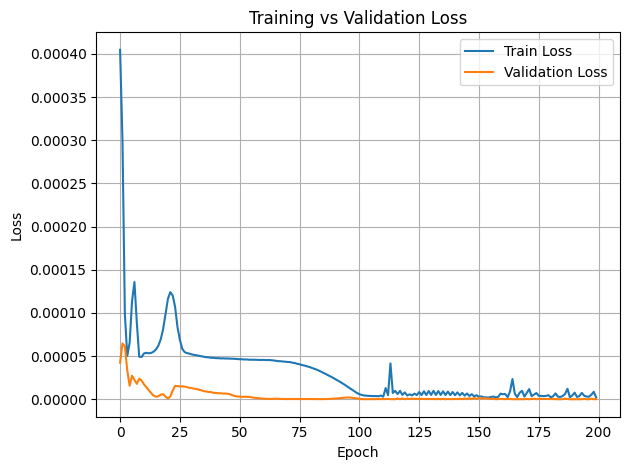

([0.0004048505117979899,
  0.0002996876310987773,
  9.88138920557834e-05,
  5.0191891363934616e-05,
  6.56724327631702e-05,
  0.00011364508514914591,
  0.0001358330635519358,
  8.861790171753692e-05,
  4.933290960709965e-05,
  4.902540593188963e-05,
  5.319187441572963e-05,
  5.380633814088366e-05,
  5.3306808227530794e-05,
  5.373594560286289e-05,
  5.513700271189944e-05,
  5.7753134948318966e-05,
  6.223444299151156e-05,
  6.960296809859818e-05,
  8.140447007999218e-05,
  9.894935341427733e-05,
  0.0001164422620541152,
  0.0001241434542878556,
  0.0001202601010827112,
  0.00010702067545147061,
  8.340044249198864e-05,
  6.886898666547125e-05,
  5.842788812383436e-05,
  5.460290874995363e-05,
  5.349052689173174e-05,
  5.292750883821963e-05,
  5.201405564246965e-05,
  5.148863251960088e-05,
  5.085091048514815e-05,
  5.050781361003555e-05,
  4.985376507946817e-05,
  4.9453269457832114e-05,
  4.8788745172536416e-05,
  4.858967993632229e-05,
  4.808235255766972e-05,
  4.809957141673558e

In [17]:
# Define the model parameters
# Following the research paper's instructions
input_size = 15
hidden_size = 128
num_layers = 1 # Can be changed to stack multiple LSTM layers!
output_size = 1
dataloader = train_loader

#Create the model
model = LSTM_pt(input_size, hidden_size, num_layers, output_size).to(device)
# train(model, dataloader, num_epochs = 200, learning_rate = 0.001)
train_and_validate(model,train_loader, test_loader, num_epochs = 200, learning_rate = 0.001, target_min = target_min, target_max = target_max)


### Testing the model

In [11]:
for batch_idx, (inputs, targets) in enumerate(test_loader):
    print(f"Batch {batch_idx}: Inputs Shape: {inputs.shape}, Targets Shape: {targets.shape}")

print("Total test batches:", len(test_loader))


Batch 0: Inputs Shape: torch.Size([16, 30, 15]), Targets Shape: torch.Size([16, 30, 1])
Batch 1: Inputs Shape: torch.Size([16, 30, 15]), Targets Shape: torch.Size([16, 30, 1])
Batch 2: Inputs Shape: torch.Size([16, 30, 15]), Targets Shape: torch.Size([16, 30, 1])
Batch 3: Inputs Shape: torch.Size([16, 30, 15]), Targets Shape: torch.Size([16, 30, 1])
Batch 4: Inputs Shape: torch.Size([16, 30, 15]), Targets Shape: torch.Size([16, 30, 1])
Batch 5: Inputs Shape: torch.Size([16, 30, 15]), Targets Shape: torch.Size([16, 30, 1])
Batch 6: Inputs Shape: torch.Size([16, 30, 15]), Targets Shape: torch.Size([16, 30, 1])
Batch 7: Inputs Shape: torch.Size([16, 30, 15]), Targets Shape: torch.Size([16, 30, 1])
Batch 8: Inputs Shape: torch.Size([16, 30, 15]), Targets Shape: torch.Size([16, 30, 1])
Batch 9: Inputs Shape: torch.Size([16, 30, 15]), Targets Shape: torch.Size([16, 30, 1])
Batch 10: Inputs Shape: torch.Size([16, 30, 15]), Targets Shape: torch.Size([16, 30, 1])
Total test batches: 11


Average Validation Loss: 0.0000002253


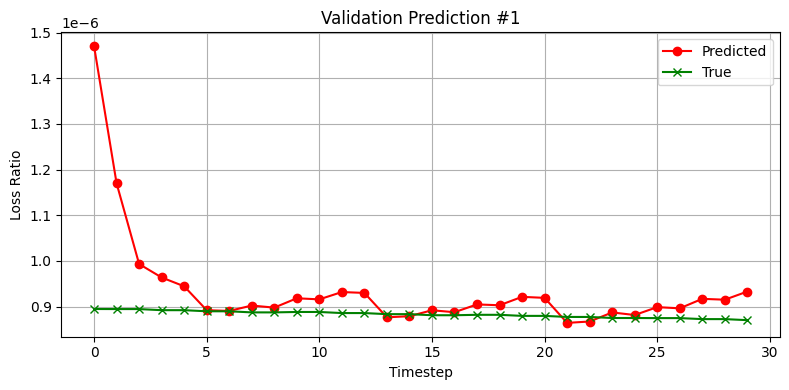

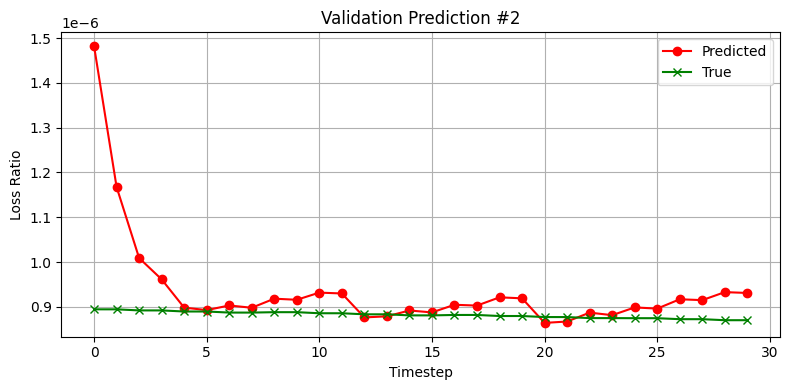

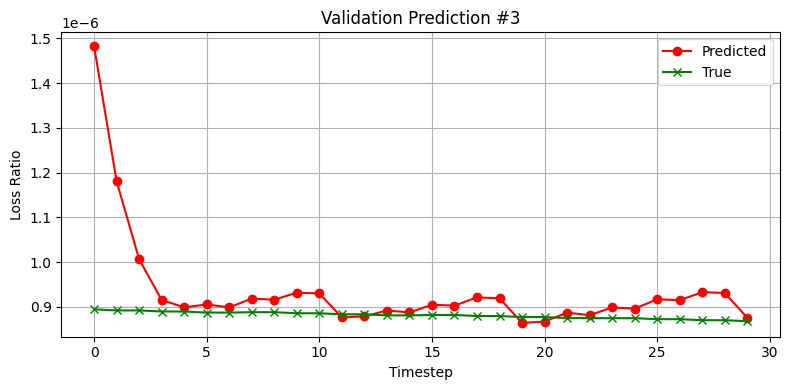

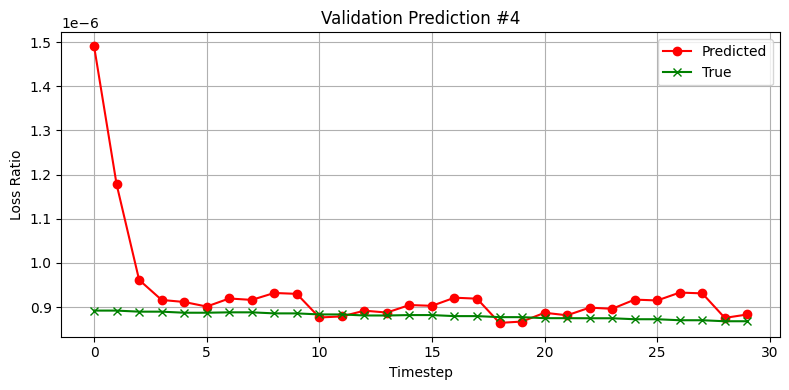

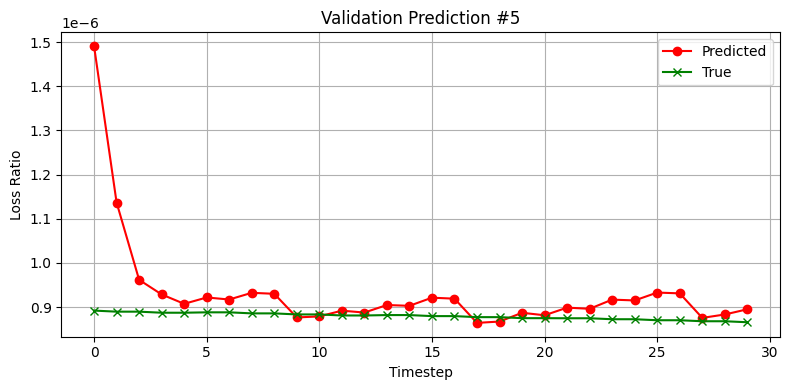

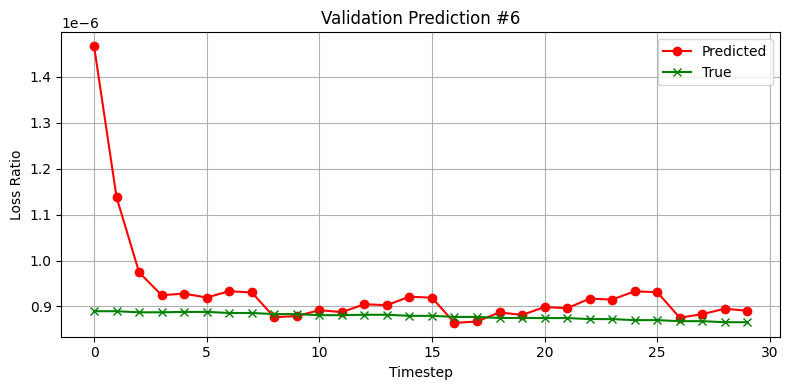

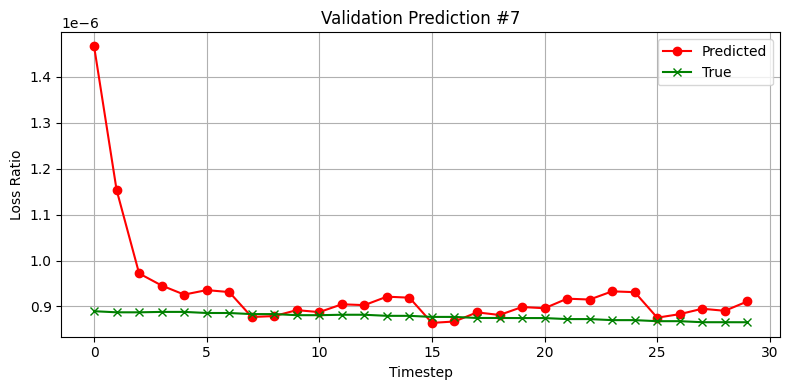

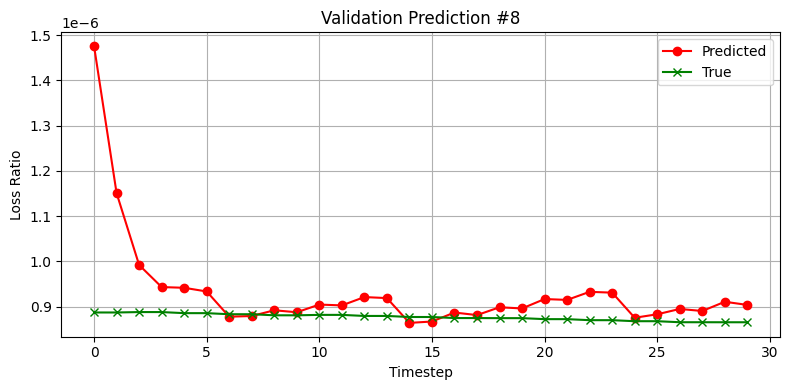

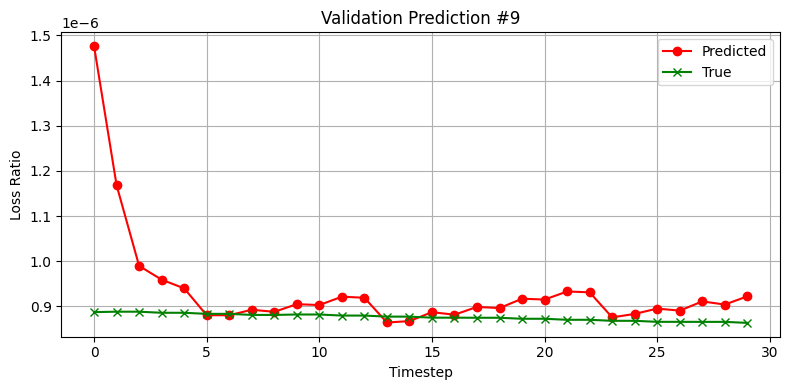

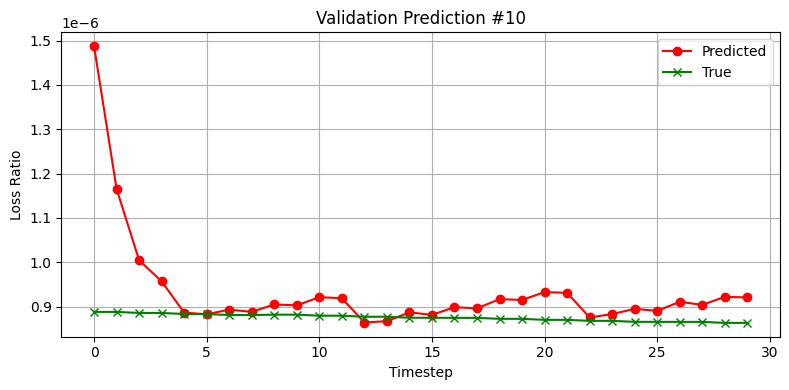

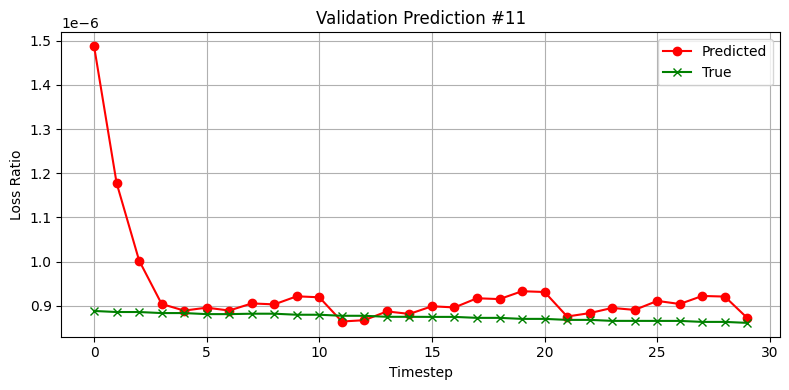

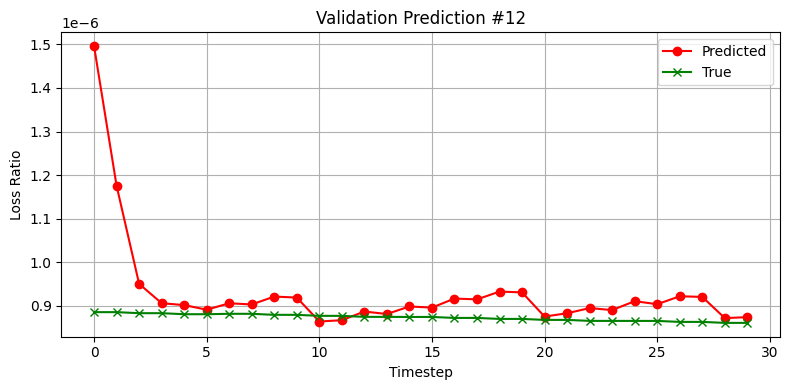

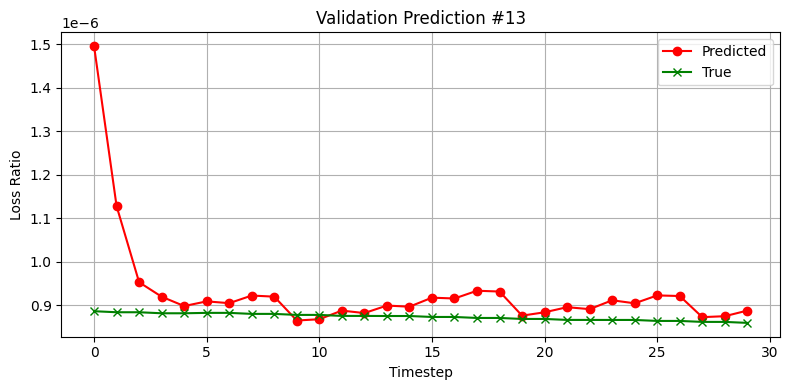

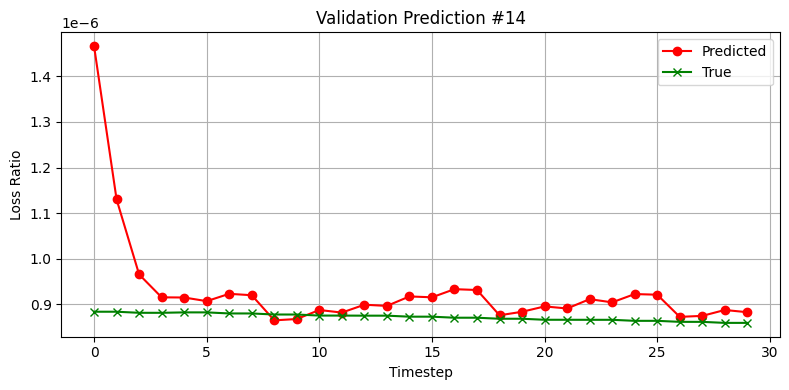

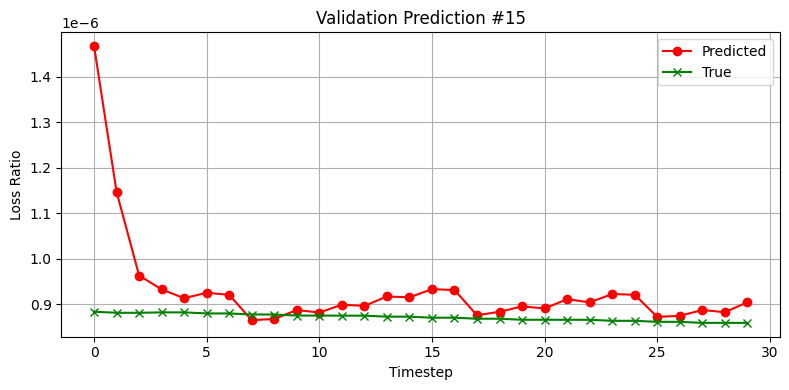

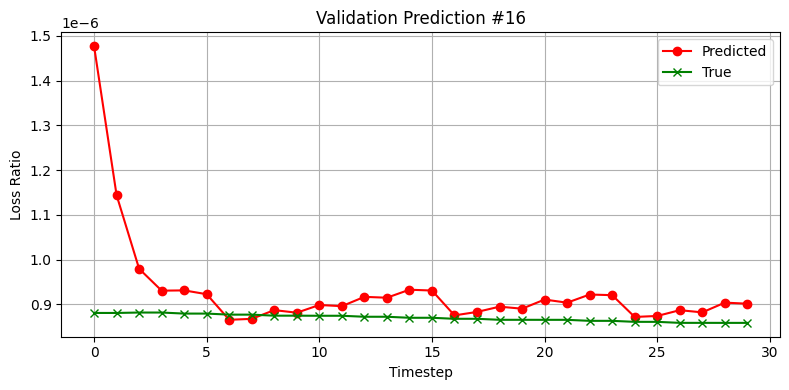

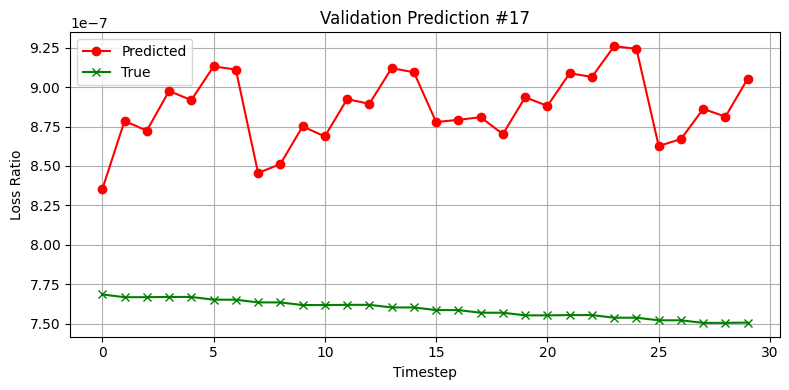

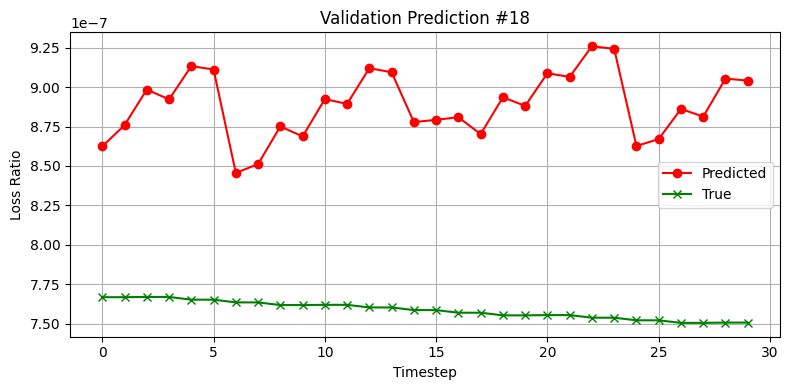

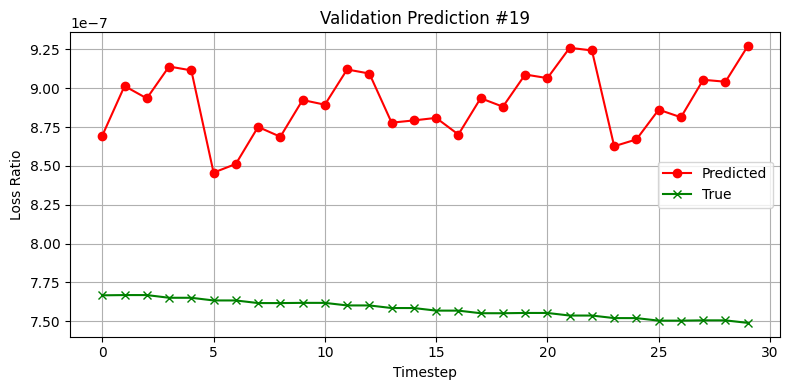

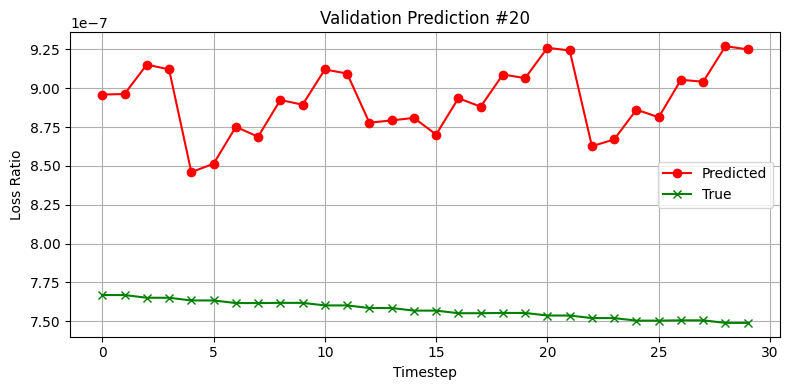

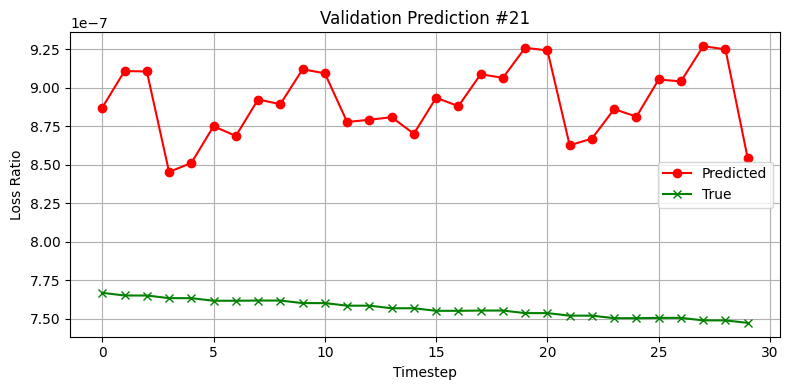

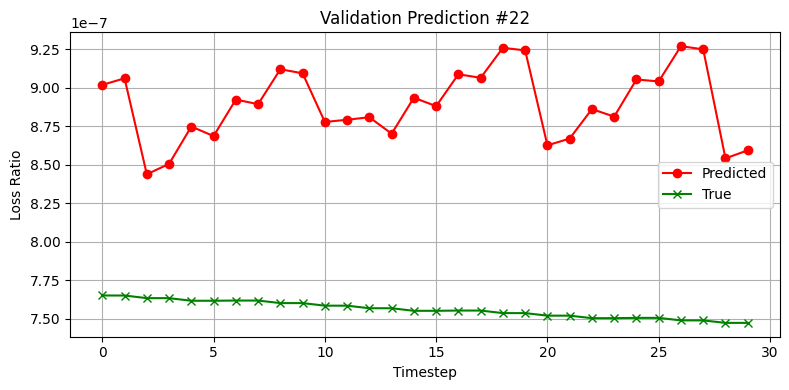

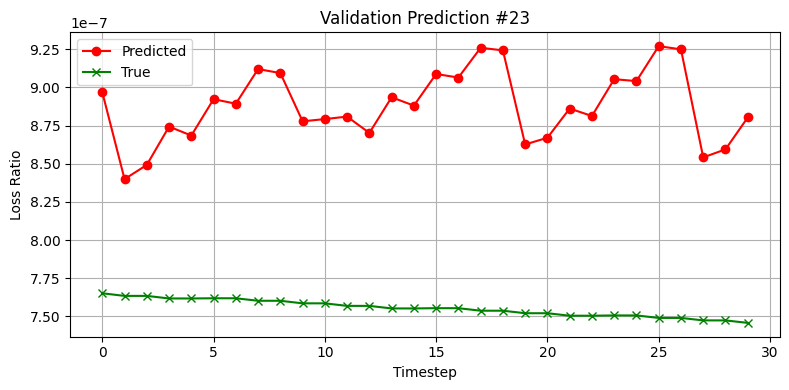

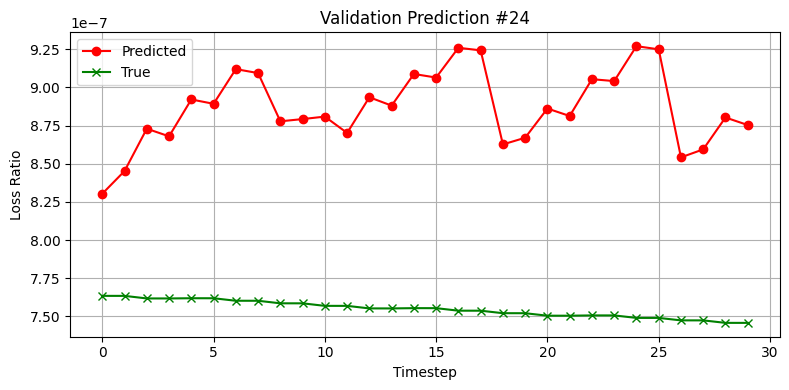

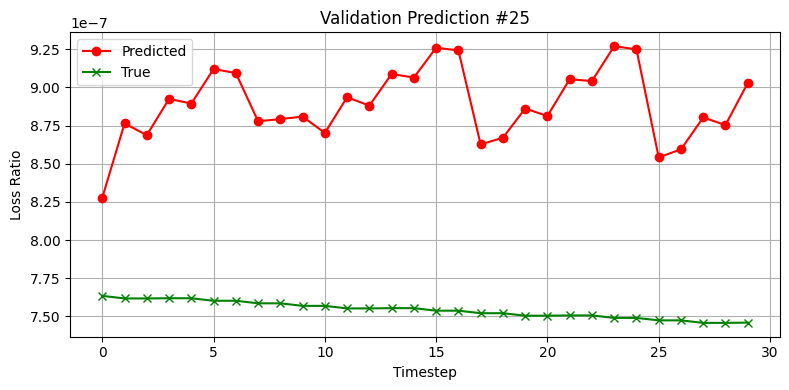

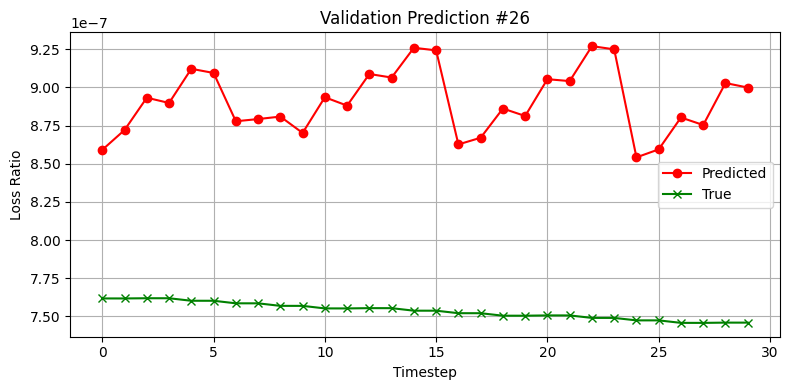

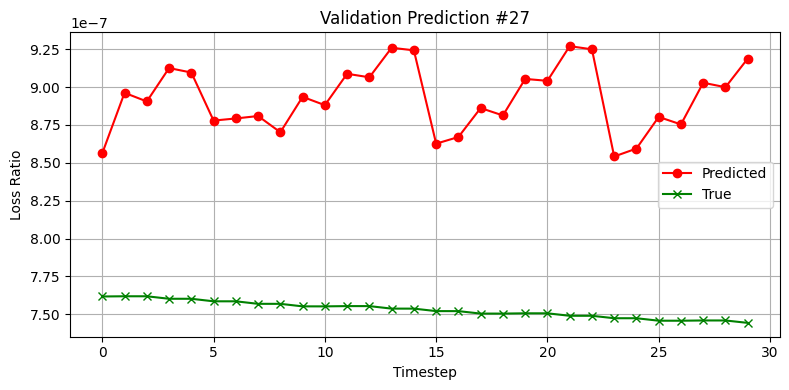

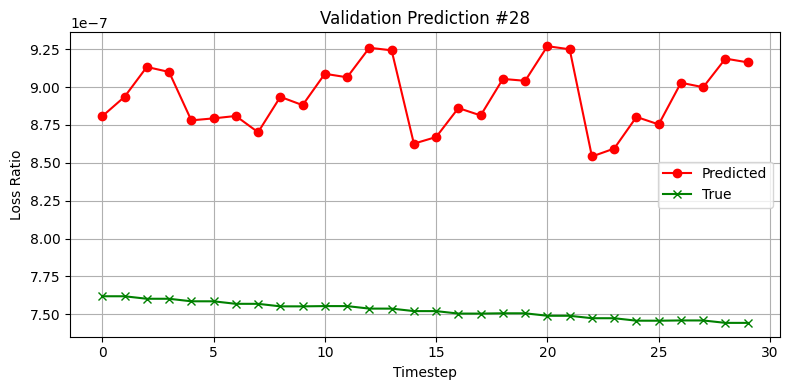

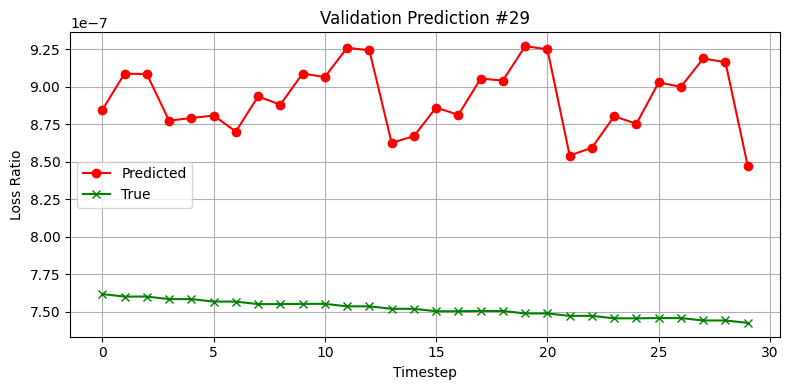

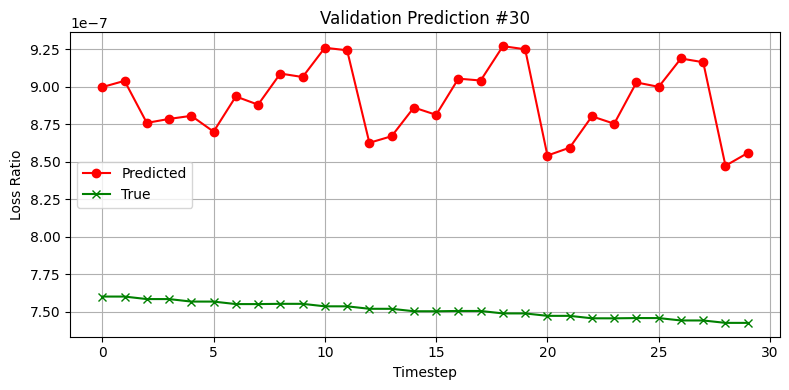

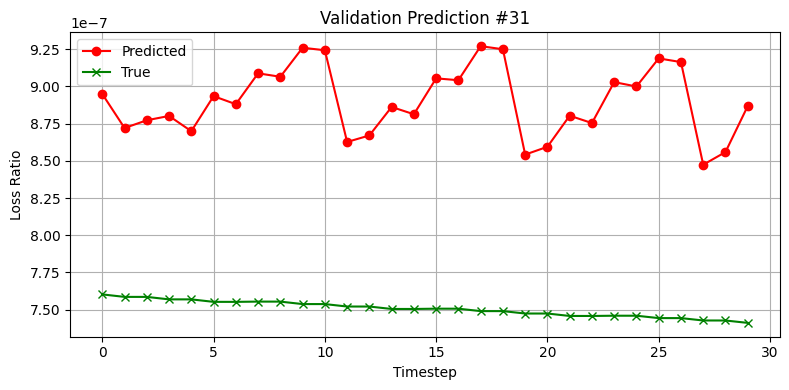

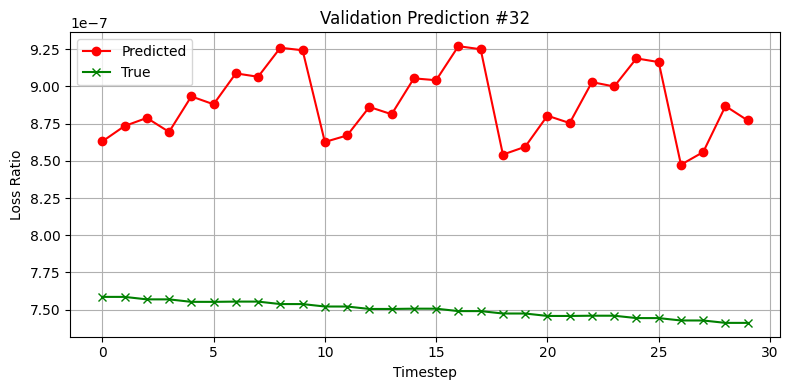

In [18]:
import torch
import matplotlib.pyplot as plt

model.eval()

# Initialize variables to track loss
total_val_loss = 0
num_batches = 0
total_lost_values = []

# Define the loss function
criterion = torch.nn.MSELoss()

# Initialize lists for storing visualized data
predicted_loss_ratios = []
true_loss_ratios = []

# Hidden state and cell state
hidden_state, cell_state = None, None  

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        if hidden_state is not None:
            hidden_state = hidden_state.detach()
        if cell_state is not None:
            cell_state = cell_state.detach()

        # Forward pass
        output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)

        # Denormalize using new min/max for target
        output_denorm = output * (target_max - target_min) + target_min
        target_denorm = targets * (target_max - target_min) + target_min

        # Append each sequence (shape [15,1] -> [15]) as a pair
        if batch_idx % 10 == 0:
            for pred_seq, true_seq in zip(output_denorm.squeeze().cpu(), target_denorm.squeeze().cpu()):
                predicted_loss_ratios.append(pred_seq.numpy())
                true_loss_ratios.append(true_seq.numpy())

        # Compute loss using normalized values
        loss = criterion(output, targets)

        # Accumulate and average loss
        total_val_loss += loss.item()
        total_lost_values.append(total_val_loss / (batch_idx + 1))
        num_batches += 1

# Average loss across all batches
avg_loss = total_val_loss / num_batches
print(f'Average Validation Loss: {avg_loss:.10f}')

# Plot each prediction vs target in separate graphs
for i, (pred, true) in enumerate(zip(predicted_loss_ratios, true_loss_ratios)):
    plt.figure(figsize=(8, 4))
    plt.plot(pred, label='Predicted', color='red', marker='o')
    plt.plot(true, label='True', color='green', marker='x')
    plt.title(f'Validation Prediction #{i+1}')
    plt.xlabel('Timestep')
    plt.ylabel('Loss Ratio')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Optional: Limit number of plots if too many
    # if i >= 10: break


Predicted output (denorm): tensor([[1.7604e-06],
        [1.1662e-06],
        [1.0263e-06],
        [1.0082e-06],
        [9.9765e-07],
        [9.4223e-07],
        [9.4132e-07],
        [9.6016e-07],
        [9.5833e-07],
        [9.7708e-07],
        [9.7604e-07],
        [9.9122e-07],
        [9.9013e-07],
        [9.3170e-07],
        [9.3314e-07],
        [9.5204e-07],
        [9.5043e-07],
        [9.6803e-07],
        [9.6706e-07],
        [9.8405e-07],
        [9.8256e-07],
        [9.2494e-07],
        [9.2610e-07],
        [9.4761e-07],
        [9.4551e-07],
        [9.6371e-07],
        [9.6182e-07],
        [9.8104e-07],
        [9.8006e-07],
        [9.9732e-07]])
True output (denorm):     tensor([[8.9473e-07],
        [8.9459e-07],
        [8.9458e-07],
        [8.9216e-07],
        [8.9215e-07],
        [8.8974e-07],
        [8.8973e-07],
        [8.8733e-07],
        [8.8731e-07],
        [8.8823e-07],
        [8.8823e-07],
        [8.8584e-07],
        [8.8583e-07],


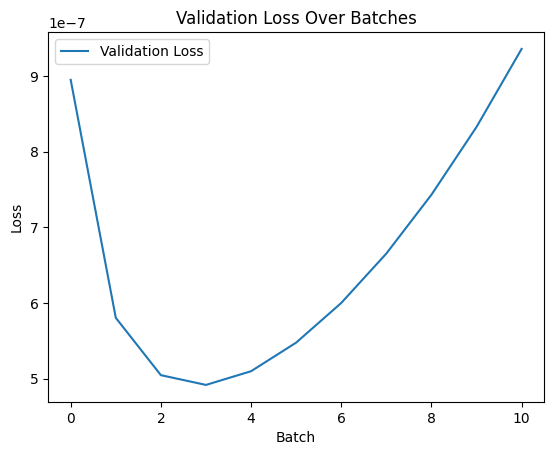

In [12]:
model.eval()

# Initialize variables to track loss
total_val_loss = 0
num_batches = 0
total_lost_values = []

# Define the loss function
criterion = torch.nn.MSELoss()

# Hidden state and cell state
hidden_state, cell_state = None, None  

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        if hidden_state is not None:
            hidden_state = hidden_state.detach()
        if cell_state is not None:
            cell_state = cell_state.detach()

        # Forward pass
        output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)

        # Denormalize using new min/max for target
        output_denorm = output * (target_max - target_min) + target_min
        target_denorm = targets * (target_max - target_min) + target_min

        if batch_idx % 5 == 0:
            print("Predicted output (denorm):", output_denorm[0])
            print("True output (denorm):    ", target_denorm[0])

        # Compute loss using normalized values
        loss = criterion(output, targets)

        # Accumulate and average loss
        total_val_loss += loss.item()
        total_lost_values.append(total_val_loss / (batch_idx + 1))
        num_batches += 1

# Average loss across all batches
avg_loss = total_val_loss / num_batches
print(f'Average Validation Loss: {avg_loss:.10f}')

# Plot the validation loss over batches
import matplotlib.pyplot as plt
plt.plot(range(num_batches), total_lost_values, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Batches')
plt.legend()
plt.show()


In [13]:
print("output size", output.shape)
print("targets size", targets.shape)

output size torch.Size([16, 30, 1])
targets size torch.Size([16, 30, 1])


In [14]:
# Example raw input: [seq_len, num_features] (unnormalized)
# Use one test sequence (unnormalized)
raw_input = X_test[0]  # shape: [15, 12] – already a tensor if you did earlier prep

# Convert to numpy if it's a tensor
raw_input_np = raw_input.numpy()

# Normalize input using feature-wise min and max (excluding loss_ratio)
normalized_input = (raw_input_np - features_min.values) / (features_max.values - features_min.values)
normalized_input = torch.tensor(normalized_input, dtype=torch.float32).unsqueeze(0)  # [1, seq_len, num_features]

# Prepare target loss_ratio min and max (use float)
target_min = float(df['loss_ratio'].min())
target_max = float(df['loss_ratio'].max())

with torch.no_grad():
    hidden_state, cell_state = None, None
    output, _, _ = model(normalized_input, cell_state, hidden_state)

    # Denormalize the output
    output_denorm = output * (target_max - target_min) + target_min

    print("Normalized model output:", output)
    print("Denormalized prediction:", output_denorm)

avg_prediction = output_denorm.mean().item()

print(f"Average Denormalized Prediction: {avg_prediction:.10f}")



Normalized model output: tensor([[[0.0852],
         [0.1448],
         [0.1774],
         [0.1907],
         [0.1956],
         [0.1975],
         [0.1983],
         [0.1988],
         [0.1991],
         [0.1993],
         [0.1995],
         [0.1997],
         [0.1999],
         [0.2001],
         [0.2002],
         [0.2003],
         [0.2005],
         [0.2006],
         [0.2007],
         [0.2007],
         [0.2008],
         [0.2009],
         [0.2010],
         [0.2010],
         [0.2011],
         [0.2011],
         [0.2012],
         [0.2012],
         [0.2013],
         [0.2013]]])
Denormalized prediction: tensor([[[1.7013e-05],
         [2.8927e-05],
         [3.5431e-05],
         [3.8090e-05],
         [3.9074e-05],
         [3.9447e-05],
         [3.9609e-05],
         [3.9698e-05],
         [3.9760e-05],
         [3.9810e-05],
         [3.9854e-05],
         [3.9892e-05],
         [3.9927e-05],
         [3.9959e-05],
         [3.9987e-05],
         [4.0012e-05],
         [

In [15]:
def run_RenoCubic(input_30):
    with torch.no_grad():
        hidden_state, cell_state = None, None
        output, _, _ = model(normalized_input, cell_state, hidden_state)

        # Denormalize the output
        output_denorm = output * (target_max - target_min) + target_min

        print("Normalized model output:", output)
        print("Denormalized prediction:", output_denorm)
        avg_prediction = output_denorm.mean().item()
        print(f"Average Denormalized Prediction: {avg_prediction:.10f}")


    return avg_prediction

def run_Reno(input_30):
    with torch.no_grad():
            hidden_state, cell_state = None, None

            #Change model to renoModel
            output, _, _ = model(normalized_input, cell_state, hidden_state)

            # Denormalize the output
            output_denorm = output * (target_max - target_min) + target_min

            print("Normalized model output:", output)
            print("Denormalized prediction:", output_denorm)
            avg_prediction = output_denorm.mean().item()
            print(f"Average Denormalized Prediction: {avg_prediction:.10f}")


    return avg_prediction


def run_Cubic(input_30):
    with torch.no_grad():
            hidden_state, cell_state = None, None
            #Change model to cubicModel
            output, _, _ = model(normalized_input, cell_state, hidden_state)

            # Denormalize the output
            output_denorm = output * (target_max - target_min) + target_min

            print("Normalized model output:", output)
            print("Denormalized prediction:", output_denorm)
            avg_prediction = output_denorm.mean().item()
            print(f"Average Denormalized Prediction: {avg_prediction:.10f}")


    return avg_prediction


def choose_model(model_input, input_30):
    #Reno is 1, cubic is 0
    if model_input == 1:
        avg_RenoCubic_result = run_RenoCubic(input_30)
        avg_Reno_result = run_Reno(input_30)

        if avg_RenoCubic_result > avg_Reno_result:
            return 1
        else:
            return 0

    #CC is cubic
    if model_input == 0:
        avg_RenoCubic_result = run_RenoCubic(input_30)
        avg_Cubic_result = run_Cubic(input_30)

        if avg_RenoCubic_result > avg_Reno_result:
            return 0
        else:
            return 1




In [16]:
torch.save(model.state_dict(), "Reno_weights.pth")
